# Post-process of constraining FaIR samples

Output image files
- Range plot: constrained indicators `range_fair-inds_single-combined_ar6-alt`
- Histogram: RMSE GSAT changes `histogram-gsat-rmse-alt`

In [1]:
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
from netCDF4 import Dataset
import h5py

In [2]:
%cd ..

c:\Users\tsutsui\Projects\ar6-tlm


c:\Users\tsutsui\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
# mce is available in https://github.com/tsutsui1872/mce 
sys.path.append('../mce')

In [4]:
from src.stats import asymmetric_gaussian
from src.plot import MyPlot # depends on mce module

## Read results

Output of 070_constraining_fair.ipynb

### Original constraining indicators

temp is RMSE of GSAT changes over 1850-2014

In [5]:
with Dataset('./dataout/constraining_fair_indicators.nc') as ncf:
    df_ind = pd.DataFrame({
        k: v[:]
        for k, v in ncf.variables.items() if k not in ncf.dimensions
    })

df_ind

,temp,ohu,co2,af,accept_prob
0,0.136237,397.316364,419.263371,0.723033,0.808039
1,0.207727,223.470121,390.941930,0.582259,0.284925
2,0.151000,476.872716,405.560091,0.636184,0.528375
3,0.231475,348.336252,390.720466,0.478787,0.673092
4,0.132073,385.308883,406.665890,0.681039,0.477075
...,...,...,...,...,...
999995,0.123470,305.272686,410.212667,0.619558,0.613447
999996,0.130145,429.925269,393.753705,0.655032,0.495022
999997,0.130061,343.231142,408.870102,0.650343,0.272083
999998,0.124775,401.466047,406.619909,0.633387,0.589491


### Alternative constraining indicators

temp is GSAT change in 1995-2014

OHU is already multiplied with 0.90 of an assumed ocean share of energy gain

In [6]:
with Dataset('./dataout/constraining_fair_indicators_alt.nc') as ncf:
    df_ind_alt = pd.DataFrame({
        k: v[:]
        for k, v in ncf.variables.items() if k not in ncf.dimensions
    })

df_ind_alt

,temp,ohu,co2,af,temp_trend
0,1.030117,357.584727,419.263371,0.723033,0.615201
1,0.529449,201.123109,390.941930,0.582259,0.457023
2,1.108875,429.185444,405.560091,0.636184,0.652434
3,1.257238,313.502627,390.720466,0.478787,0.665233
4,1.023911,346.777995,406.665890,0.681039,0.713374
...,...,...,...,...,...
999995,0.935454,274.745417,410.212667,0.619558,0.543070
999996,0.972869,386.932743,393.753705,0.655032,0.619115
999997,0.798537,308.908028,408.870102,0.650343,0.587545
999998,0.877288,361.319442,406.619909,0.633387,0.647005


### Constrained members by the original method

In [7]:
with Dataset('./dataout/constraining_fair_accept.nc') as ncf:
    df_accept = pd.DataFrame({
        k: v[:]
        for k, v in ncf.variables.items() if k not in ncf.dimensions
    }).astype('bool')

df_accept

,temp,ohu,co2,temp_ohu_co2,af_combined,af_single
0,False,True,False,False,False,False
1,False,False,False,False,False,True
2,False,True,False,False,False,True
3,False,False,False,False,False,False
4,True,True,False,False,False,False
...,...,...,...,...,...,...
999995,True,False,False,False,False,True
999996,True,True,False,False,False,True
999997,True,False,False,False,False,True
999998,True,True,False,False,False,True


In [8]:
df_accept.sum()

temp            311968
ohu             322738
co2              21560
temp_ohu_co2      3751
af_combined       2237
af_single       442554
dtype: int64

### Constrained members by the alternative method

In [9]:
with h5py.File('./dataout/constraining_fair_mhout.h5') as f1:
    mhout = {k: v[:] for k, v in f1['/mhout'].items()}
    member_rand = {k: v[:] for k, v in f1['/member'].items()}

In [10]:
list(mhout), list(member_rand)

(['af__single',
  'all',
  'co2__single',
  'co2_pre',
  'ohu__single',
  'temp_&_temp_trend',
  'temp_&_temp_trend_&_ohu',
  'temp__single',
  'temp_trend__single'],
 ['af__single',
  'all',
  'co2__single',
  'co2_pre',
  'ohu__single',
  'temp_&_temp_trend',
  'temp_&_temp_trend_&_ohu',
  'temp__single',
  'temp_trend__single'])

## Reference ranges

In [11]:
NINETY_TO_ONESIGMA = stats.norm.ppf(0.95)

map_rv = {
    'temp': # GSAT 1995-2014
    pd.Series(asymmetric_gaussian(0.85, (0.67, 0.98))),
    'ohu': # OHU 2018 relto 1971
    stats.norm(loc=396.0, scale=0.5*(506.2 - 285.7)/NINETY_TO_ONESIGMA),
    'co2': # CO2 2014
    # Use the RCMIP central value of 397.547 ppm for consistency
    # instead of 397.1 ppm
    stats.norm(loc=397.547, scale=0.4/NINETY_TO_ONESIGMA),
    'af': # AF 140
    stats.norm(loc=.597, scale=.049),
    'temp_trend':
    stats.norm(
        loc=0.85 - 0.36,
        scale=np.sqrt(
            asymmetric_gaussian(0.36, (0.22, 0.45)).var(ddof=1)
            + asymmetric_gaussian(0.85, (0.67, 0.98)).var(ddof=1)
        ),
    )
}

## Plot settings

In [12]:
plt = MyPlot()

In [13]:
map_probability = plt.map_probability
prob_values = list(map_probability)
map_probability, prob_values

({0.05: 'very_likely__lower',
  0.17: 'likely__lower',
  0.5: 'central',
  0.83: 'likely__upper',
  0.95: 'very_likely__upper'},
 [0.05, 0.17, 0.5, 0.83, 0.95])

In [14]:
map_method = plt.map_method
map_method

{'ar6_orig': '#0 EBM-ε AR6 orig',
 'ar6': '#1 EBM-ε AR6',
 's21': '#2 EBM-ε S21',
 'mce-2l': '#3 MCE-2l'}

## Range plot: constrained indicators

In [30]:
parm_order = [
    'temp',
    'ohu',
    'co2',
    'af',
    'temp_trend',
]
dfq = {}

In [31]:
df = df_ind_alt.quantile(prob_values)
dfq[('Unconstrained', 'Unconstrained')] = df
df

,temp,ohu,co2,af,temp_trend
0.05,0.385299,171.311190,377.774514,0.335780,0.350042
0.17,0.549982,228.272491,386.088576,0.466889,0.427381
0.50,0.817807,327.892679,398.954184,0.597631,0.555499
0.83,1.178675,466.552977,411.823856,0.670325,0.735326
0.95,1.545568,604.262243,420.063332,0.704679,0.917044


In [32]:
map_parm = {
    'af': 'af_single',
    'temp_trend': 'temp',
}
df = pd.DataFrame({
    k:
    df_ind_alt.loc[df_accept[map_parm.get(k, k)], k]
    .quantile(prob_values)
    for k in parm_order
})
dfq[('Single', 'AR6')] = df
df

,temp,ohu,co2,af,temp_trend
0.05,0.701699,333.198928,397.224241,0.530081,0.417077
0.17,0.751532,345.391900,397.312306,0.562795,0.462825
0.50,0.852844,382.842472,397.548805,0.607599,0.536490
0.83,0.956788,430.170382,397.784673,0.648230,0.618351
0.95,1.007125,451.965714,397.870822,0.673565,0.676936


In [33]:
df = df_ind_alt.loc[df_accept['af_combined']].quantile(prob_values)
dfq[('Combined', 'AR6')] = df
df

,temp,ohu,co2,af,temp_trend
0.05,0.729275,332.494570,397.224222,0.533913,0.441860
0.17,0.784818,344.296022,397.311471,0.565166,0.482456
0.50,0.878390,376.822045,397.550352,0.603680,0.553300
0.83,0.970705,418.271978,397.792038,0.635775,0.633067
0.95,1.014489,443.168907,397.870747,0.653194,0.685671


In [34]:
df = pd.DataFrame({
    k:
    df_ind_alt.loc[member_rand[f'{k}__single'], k]
    .quantile(prob_values)
    for k in parm_order
})
dfq[('Single', 'Alternative')] = df
df

,temp,ohu,co2,af,temp_trend
0.05,0.680859,278.405060,397.137562,0.517607,0.313531
0.17,0.743447,330.043548,397.340030,0.551415,0.380610
0.50,0.839979,393.311783,397.528554,0.597649,0.490609
0.83,0.924539,459.974261,397.787349,0.643575,0.604103
0.95,0.991194,508.758025,397.933114,0.674068,0.690452


In [35]:
df = (
    df_ind_alt
    .loc[member_rand['co2_pre']]
    .reset_index(drop=True)
    .loc[member_rand['all']]
    .iloc[:2000]
    .quantile(prob_values)
)
dfq[('Combined', 'Alternative')] = df
df

,temp,ohu,co2,af,temp_trend
0.05,0.729040,310.134357,397.146354,0.521639,0.401029
0.17,0.783652,352.585055,397.315229,0.552386,0.444839
0.50,0.855625,401.875316,397.533511,0.597108,0.516565
0.83,0.929934,456.591934,397.754670,0.635851,0.599176
0.95,0.979134,504.171626,397.944524,0.656292,0.675180


In [36]:
df = pd.DataFrame({
    k: v.quantile(prob_values) if isinstance(v, pd.Series)
    else pd.Series(v.ppf(prob_values), index=prob_values)
    for k, v in map_rv.items()
})
dfq[('Reference', 'Reference')] = df
df

,temp,ohu,co2,af,temp_trend
0.05,0.672764,285.750000,397.147000,0.516402,0.296483
0.17,0.747173,332.044936,397.314963,0.550246,0.377743
0.50,0.850668,396.000000,397.547000,0.597000,0.490000
0.83,0.925369,459.955064,397.779037,0.643754,0.602257
0.95,0.982209,506.250000,397.947000,0.677598,0.683517


In [37]:
dfq = (
    pd.concat(dfq, axis=1)
    .reorder_levels([2, 0, 1], axis=1)
    .sort_index(axis=1)
    .rename(map_probability)
    .sort_index()
)
dfq

af                                              \
                    Combined             Reference    Single               
                         AR6 Alternative Reference       AR6 Alternative   
central             0.603680    0.597108  0.597000  0.607599    0.597649   
likely__lower       0.565166    0.552386  0.550246  0.562795    0.551415   
likely__upper       0.635775    0.635851  0.643754  0.648230    0.643575   
very_likely__lower  0.533913    0.521639  0.516402  0.530081    0.517607   
very_likely__upper  0.653194    0.656292  0.677598  0.673565    0.674068   

                                         co2                          \
                   Unconstrained    Combined               Reference   
                   Unconstrained         AR6 Alternative   Reference   
central                 0.597631  397.550352  397.533511  397.547000   
likely__lower           0.466889  397.311471  397.315229  397.314963   
likely__upper           0.670325  397.792038  397.754670  397.779037   
very_likely__lower      0.335780  397.224222  397.146354  397.147000   
very_likely__upper      0.704679  397.870747  397.944524  397.947000   

                                ...      temp                        \
                        Single  ... Reference    Single               
                           AR6  ... Reference       AR6 Alternative   
central             397.548805  ...  0.850668  0.852844    0.839979   
likely__lower       397.312306  ...  0.747173  0.751532    0.743447   
likely__upper       397.784673  ...  0.925369  0.956788    0.924539   
very_likely__lower  397.224241  ...  0.672764  0.701699    0.680859   
very_likely__upper  397.870822  ...  0.982209  1.007125    0.991194   

                                 temp_trend                                  \
                   Unconstrained   Combined             Reference    Single   
                   Unconstrained        AR6 Alternative Reference       AR6   
central                 0.817807   0.553300    0.516565  0.490000  0.536490   
likely__lower           0.549982   0.482456    0.444839  0.377743  0.462825   
likely__upper           1.178675   0.633067    0.599176  0.602257  0.618351   
very_likely__lower      0.385299   0.441860    0.401029  0.296483  0.417077   
very_likely__upper      1.545568   0.685671    0.675180  0.683517  0.676936   

                                              
                               Unconstrained  
                   Alternative Unconstrained  
central               0.490609      0.555499  
likely__lower         0.380610      0.427381  
likely__upper         0.604103      0.735326  
very_likely__lower    0.313531      0.350042  
very_likely__upper    0.690452      0.917044  

[5 rows x 30 columns]

[2024-07-14 08:41:53 mce.util] INFO:saved to ./image/range_fair-inds_single-combined_ar6-alt.png


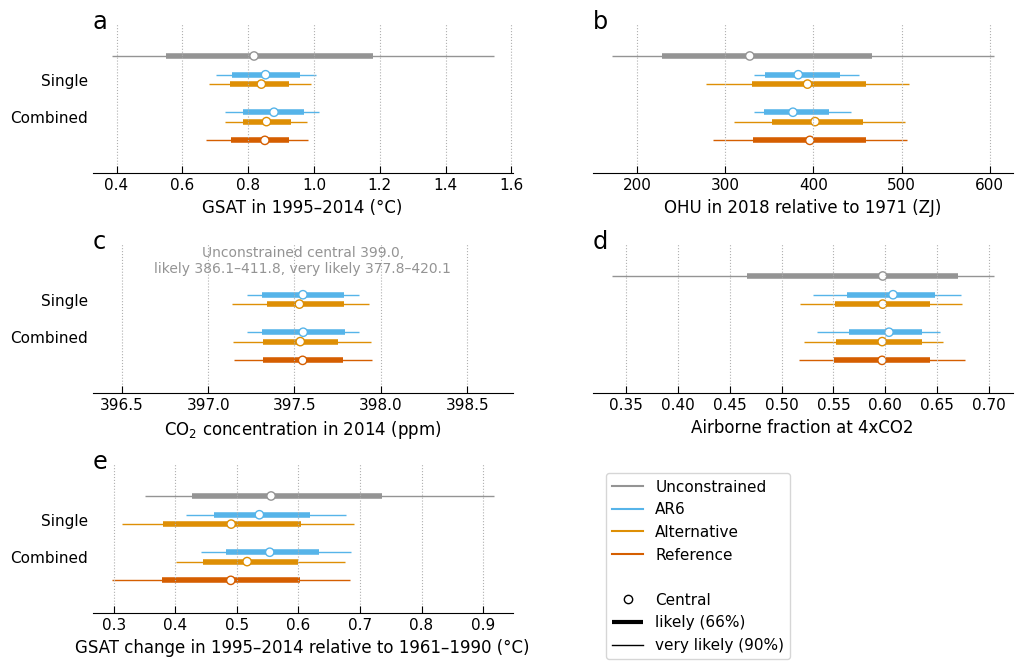

In [38]:
group_order = [
    'Unconstrained', 
    'Single',
    'Combined',
    'Reference',
]
member_order = [
    'Reference',
    'AR6',
    'Alternative',
    'Unconstrained',
]
map_color = {
    'Unconstrained': 'C7',
    'AR6': 'C9',
    'Alternative': 'C1',
    'Reference': 'C3',
}
map_name_unit = {
    'temp': ('GSAT in 1995–2014', '°C'),
    'ohu': ('OHU in 2018 relative to 1971', 'ZJ'),
    'co2': ('CO$_2$ concentration in 2014', 'ppm'),
    'af': ('Airborne fraction at 4xCO2', ''),
    'temp_trend': (
        'GSAT change in 1995–2014 relative to 1961–1990', '°C',
    ),
}

height = 1.5
width = 3. * 1.4
shrink = 1.
plt.init_regular(
    len(parm_order), col=2,
    kw_space={'height': height, 'aspect': width/height},
)
plt.plot_quantile_range(
    dfq, axes=plt(),
    parm_order=parm_order,
    group_order=group_order,
    member_order=member_order,
    map_color=map_color,
    map_name_unit=map_name_unit,
    shrink=shrink,
)

# Exchange legend items
map_exchange = {0: 3, 3: 0}
legend = plt.figure.legends[0]
try:
    handles = legend.legendHandles
except:
    handles = legend.legend_handles

handles = [
    handles[map_exchange.get(i, i)]
    for i in range(len(handles))
]
labels = [
    legend.texts[map_exchange.get(i, i)]._text
    for i in range(len(legend.texts))
]
legend.remove()
plt.figure.legend(
    handles, labels,
    loc='upper left',
    bbox_to_anchor=plt.get_fig_position_relto_axes((0.55, 0.25)),
)

# Modify panel c for visibility
# Adjust xlim
ax = plt(2)
mean = map_rv['co2'].mean()
std = map_rv['co2'].std()
ax.set_xlim(mean-5*std, mean+5*std)

# Make unconstrained invisible by changing the color transparent
slc = slice(
    member_order.index('Unconstrained'),
    None,
    len(member_order),
)
for i in [0, 1]:
    colors = ax.collections[i].get_color()
    colors[slc] = 0.
    ax.collections[i].set_color(colors)

colors = ax.collections[2].get_edgecolors()
colors[slc] = 0.
ax.collections[2].set_edgecolors(colors)

# Write text instead
xm = 0.5 * (mean-5*std + mean+5*std)
yvals = np.arange(4 * 4)[::-1].reshape((-1, 4)) + 0.5
ym = yvals.mean(axis=1)
yvals = ((yvals - ym[:, None]) * shrink + ym[:, None]).ravel()
d1 = dfq[('co2', 'Unconstrained', 'Unconstrained')]
text = 'Unconstrained central {:.1f},\nlikely {:.1f}–{:.1f}, very likely {:.1f}–{:.1f}'.format(
    d1.central,
    d1.likely__lower, d1.likely__upper,
    d1.very_likely__lower, d1.very_likely__upper,
)
ax.annotate(
    text, (xm, yvals[3]),
    ha='center', va='bottom', fontsize='small', color=map_color['Unconstrained'],
)

# Remove unnecessary labels
for i, ax in enumerate(plt()):
    if i in [1, 3]:
        ax.tick_params(axis='y', labelleft=False, left=False)
    else:
        ax.set_yticklabels([''] + group_order[1:3] + [''])

plt.panel_label(xytext=(0., 1.), va='center')

plt.savefig('./image/range_fair-inds_single-combined_ar6-alt.png')

## Histogram

In [21]:
df_ind['temp'].loc[df_accept['temp']]

4         0.132073
6         0.116678
9         0.109183
15        0.133923
16        0.109515
            ...   
999995    0.123470
999996    0.130145
999997    0.130061
999998    0.124775
999999    0.106956
Name: temp, Length: 311968, dtype: float64

[2024-07-14 08:49:31 mce.util] INFO:saved to ./image/histogram-gsat-rmse-alt.png


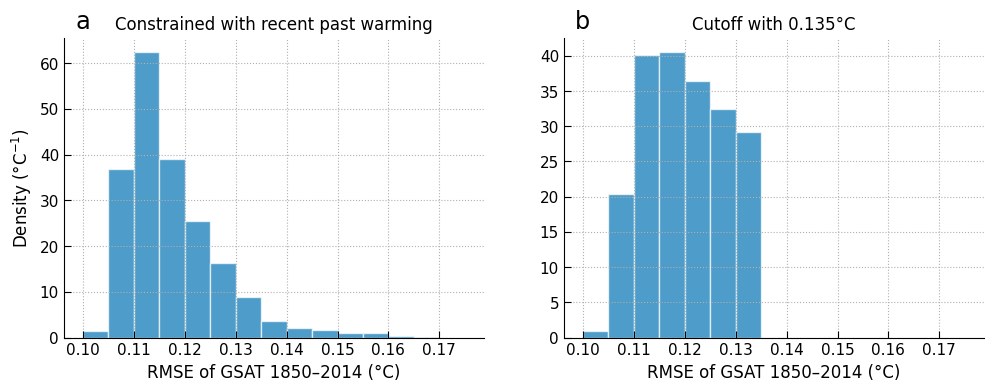

In [40]:
bins = 0.1 + 0.005 * np.arange(16)

plt.init_regular(2, col=2)

kw_hist = {'density': True, 'alpha': 0.7, 'edgecolor': 'w'}

ax = plt(0)
# _, bins, _ = ax.hist(rmse_temp[results_gsat['members'].values], bins, **kw_hist)
_, bins, _ = ax.hist(
    df_ind['temp'].loc[member_rand['temp_&_temp_trend']],
    bins, **kw_hist,
)
# ax.axvline(0.135, color='k', ls='--')
ax.set_xlabel('RMSE of GSAT 1850–2014 (°C)'),
ax.set_ylabel('Density (°C$^{−1}$)'),
ax.set_title('Constrained with recent past warming')
ax.grid()

ax = plt(1)
# ax.hist(rmse_temp[accept_temp], bins, **kw_hist)
ax.hist(
    df_ind['temp'].loc[df_accept['temp']].values,
    bins, **kw_hist,
)
# ax.axvline(0.135, color='k', ls='--')
ax.set_xlabel('RMSE of GSAT 1850–2014 (°C)'),
ax.set_title('Cutoff with 0.135°C')
ax.grid()

plt.axis_share(axis='x')
plt.panel_label()
plt.savefig('./image/histogram-gsat-rmse-alt.png')